In [1]:
from functions import group_power_range_btwn_sd, power_plot_group, est_win_sub_mod_sd, calc_group_eff_size
import numpy as np
import matplotlib.pyplot as plt

/Users/jeanettemumford/.pyenv/versions/3.8.5/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
figure_directory = '/Users/jeanettemumford/Dropbox/Research/Projects/RT_sims/Figures'
display_plots = True

nsub = 30
n_trials = 30
scan_length = 225
repetition_time = 1
mu_grinband_shift = 638
inv_lambda_grinband_shift = 699
sigma_grinband_shift = 103
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
max_rt = 8000
min_rt = 50
event_duration = .5  
center_rt=True
hp_filter = True
ISI_min = 3
ISI_max = 6
nsim_sd_est = 100
nsim_power = 1000


beta = {'dv_scales_yes': 3, 'dv_scales_no': 15}
win_sub_noise_sd = {'dv_scales_yes': 3, 'dv_scales_no': .5}

win_sub_mod_sd = est_win_sub_mod_sd(n_trials, scan_length, 
              repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, center_rt,
              hp_filter, nsim_sd_est)

btwn_sub_noise_sd_vec = {'dv_scales_yes': np.array([0, 3, 6, 7, 15, 20]),
                         'dv_scales_no': np.array([0, 20, 40, 50, 80, 110])}
all_sd_params = {'win_sub_noise_sd': win_sub_noise_sd,
                 'win_sub_mod_sd': win_sub_mod_sd,
                 'btwn_noise_sd_vec': btwn_sub_noise_sd_vec}



In [3]:
eff_sizes = calc_group_eff_size(all_sd_params, beta)
print(eff_sizes)

{'dv_scales_yes': {'total_within_sd_ratio': array([ 1.        ,  1.81735197,  3.19547692,  3.67930612,  7.65305199,
       10.16588673]), 'cohens_d': array([1.51748746, 0.83499921, 0.47488606, 0.41243849, 0.19828527,
       0.14927251])}, 'dv_scales_no': {'total_within_sd_ratio': array([ 1.        ,  2.34995802,  4.36912013,  5.40965727,  8.56486093,
       11.73880982]), 'cohens_d': array([1.59492798, 0.67870488, 0.36504558, 0.29482976, 0.18621762,
       0.13586795])}}


Scales yes between-subject SD = 0

Scales no between-subject SD = 0



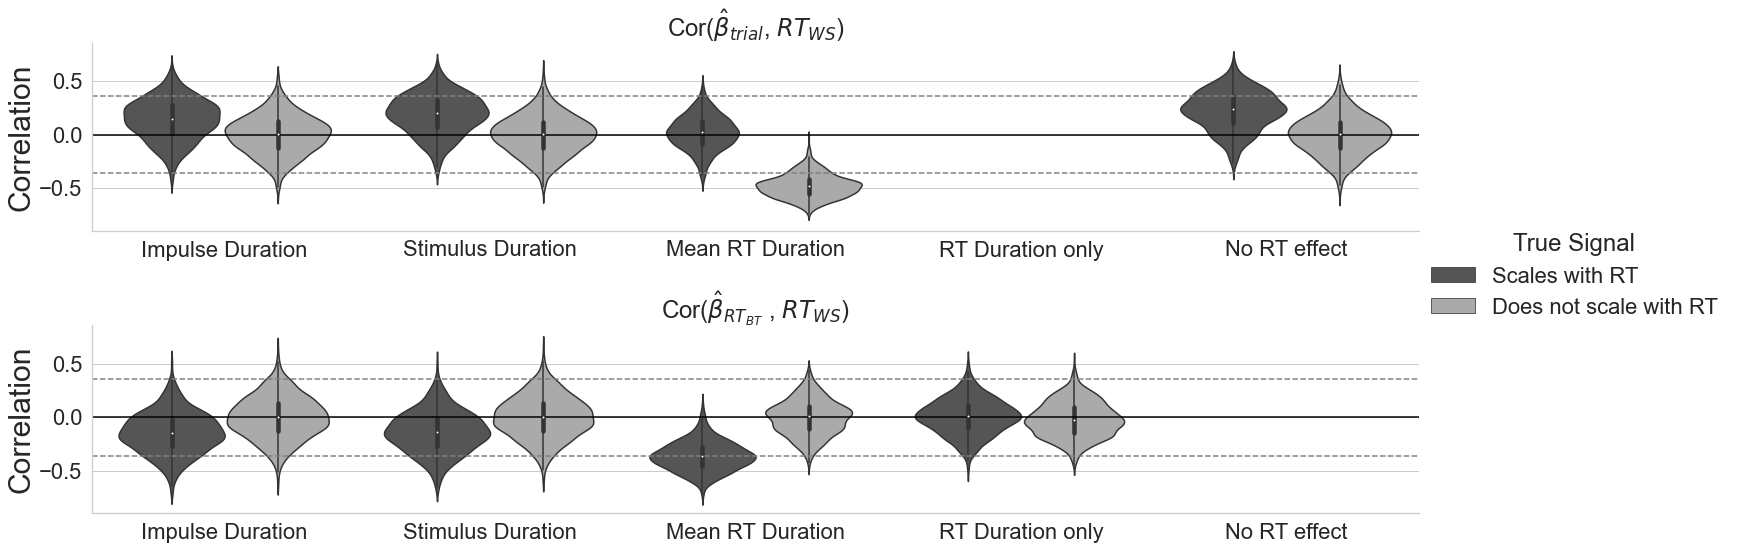

KeyboardInterrupt: 

In [4]:
output_forced_choice = group_power_range_btwn_sd(n_trials, scan_length, repetition_time, 
              mu_expnorm, lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, all_sd_params, 
              nsub, nsim_power, center_rt, beta, hp_filter, figure_directory, display_plots)

In [ ]:
power_plot_group(output_forced_choice, figure_directory, 
                     zoom=False, show_rt_mod=False, display_plots)

In [ ]:
power_plot_group(output_forced_choice, figure_directory, 
                     zoom=False, show_rt_mod=True, display_plots)

In [ ]:
#Stroop settings
mu_expnorm = 530
lam_expnorm = 1 / 160
sigma_expnorm = 77

In [ ]:
beta = {'dv_scales_yes': 1.7, 'dv_scales_no': 8}
win_sub_noise_sd = {'dv_scales_yes': 1.25, 'dv_scales_no': .5}
win_sub_mod_sd = est_win_sub_mod_sd(n_trials, scan_length, 
              repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, center_rt,
              hp_filter, nsim_sd_est)
btwn_sub_noise_sd_vec = {'dv_scales_yes': np.array([3.5]),
                         'dv_scales_no': np.array([16])}
all_sd_params = {'win_sub_noise_sd': win_sub_noise_sd,
                 'win_sub_mod_sd': win_sub_mod_sd,
                 'btwn_noise_sd_vec': btwn_sub_noise_sd_vec}

In [ ]:
eff_sizes = calc_group_eff_size(all_sd_params, beta)
print(eff_sizes)

In [ ]:
nsub = 30
print(f'Results with {nsub} subjects')
output_stroop = group_power_range_btwn_sd(n_trials, scan_length, repetition_time, 
              mu_expnorm, lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, all_sd_params, 
              nsub, nsim_power, center_rt, beta, hp_filter, figure_directory, display_plots)

In [ ]:
nsub = 50
print(f'Results with {nsub} subjects')
output_stroop = group_power_range_btwn_sd(n_trials, scan_length, repetition_time, 
              mu_expnorm, lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, all_sd_params, 
              nsub, nsim_power, center_rt, beta, hp_filter, figure_directory, display_plots)